<a href="https://colab.research.google.com/github/ludo950/BERT-emotion-analysis/blob/main/BERT_93_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#IO packages
import io
from google.colab import drive 

#data processing
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler

#BERT and keras
!pip install transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_data = pd.read_csv('gdrive/My Drive/BERT PROJECT/train.txt', header =None, sep =';', names = ['text','emotion'], encoding='utf-8')
test_data = pd.read_csv('gdrive/My Drive/BERT PROJECT/test.txt',header =None, sep =';', names = ['text','emotion'], encoding='utf-8')
val_data = pd.read_csv('gdrive/My Drive/BERT PROJECT/val.txt', header =None, sep =';', names = ['text','emotion'], encoding='utf-8')

Lets analyze the head of the train dataset

In [ ]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [ ]:
train_data.shape

(16000, 2)

In [ ]:
val_data.shape

(2000, 2)

In [ ]:
test_data.shape

(2000, 2)

There are 16'000 sentences for train, 2000 for validation and 2000 for testing.

# Preprocessing

We will check the count of each emotion in the train dataset.

In [ ]:
train_data['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

The dataset looks indeed unbalanced. In the following, it will be balanced by using RandomOversampler.

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1));
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion']);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Encoding for categorical variables

The column "emotion" will be encoded by means of OneHotEnconding, since after some tests it resulted into a higher accuracy when compared to a simple label encoding.

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train= ohe.fit_transform(np.array(train['emotion']).reshape(-1, 1)).toarray()
y_test= ohe.fit_transform(np.array(test_data['emotion']).reshape(-1, 1)).toarray()
y_val= ohe.fit_transform(np.array(val_data['emotion']).reshape(-1, 1)).toarray()

# Data Preparation for BERT

The input data to the BERT model must be first tokenized.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize(data,maximum_length) :
  input_ids = []
  attention_masks = []
  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus( 
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

The tokenize function aims to tokenize the input sentences into a specific format for BERT,

Moreover, BERT needs to know the max_len of the tokens.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


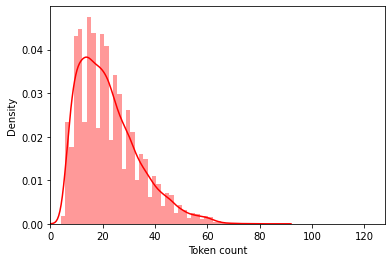

In [ ]:
token_lens = []
for txt in train_data.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens, color='red');
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
max_len=np.max(token_lens)
max_len

87

The maximum token length is 87. So, the max len parameter will be set to to 128 for robustness.

In [ ]:
max_len=128

The previously defined tokenize function will be now applied to the train, val and test sets

In [ ]:
train_input_ids,train_attention_masks = tokenize(train, max_len)
test_input_ids,test_attention_masks = tokenize(test_data, max_len)
val_input_ids,val_attention_masks = tokenize(val_data, max_len)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In the following, a function "create_model" will define the BERT model with a neual network wich will be fine tuned using the training dataset.

In [ ]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(12, activation=tf.nn.relu)(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(6, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

The pretrained BERT model 'base-uncased' will be loaded.

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model, max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           9228        tf_bert_model_1[0][1]      

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4,batch_size=128)

Epoch 1/2


In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

In [ ]:
classification_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       275
           1       0.95      0.83      0.89       224
           2       0.99      0.89      0.94       695
           3       0.73      0.99      0.84       159
           4       0.99      0.94      0.97       581
           5       0.65      0.91      0.75        66

   micro avg       0.92      0.92      0.92      2000
   macro avg       0.86      0.93      0.88      2000
weighted avg       0.94      0.92      0.92      2000
 samples avg       0.92      0.92      0.92      2000
